## 5.1 합성곱 신경망 소개
간단한 컨브넷을 아래에 소개한다. 2장의 완전 연결 네트워크는 97.8%의 테스트 정확도를 얻은 반면에 기본적인 컨브넷은 99.2%의 테스트 정확도를 얻어 에러율이 상대적으로 64% 줄어든 것을 확인할 수 있다.

In [1]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [2]:
# Conv2D layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) # img_height, img_width, img_channels
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) # (output_depth, (window_height, window_width))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [3]:
# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [4]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.1680 - acc: 0.9476
Epoch 2/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0469 - acc: 0.9853
Epoch 3/5
60000/60000 [==============================] - 4s 60us/step - loss: 0.0320 - acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 4s 58us/step - loss: 0.0240 - acc: 0.9925
Epoch 5/5
60000/60000 [==============================] - 3s 57us/step - loss: 0.0188 - acc: 0.9942


In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 0s 40us/step


0.9924

### 5.1.1 합성곱 연산
완전 연결 층은 입력 특성 공간에 있는 전역 패턴을 학습하지만 합성곱 층은 지역 패턴을 학습한다. 이미지일 경우 작은 2D 윈도우를 이동하여 입력에서 패턴을 찾는다. 이 특징은 컨브넷에 두 가지 흥미로운 성질을 제공한다. 
+ 학습된 패턴은 평행 이동 불변성을 가진다.
    + 우리가 보는 세상은 평행 이동으로 인해 다르게 인식되지 않으므로 일반화 능력이 우수하다.
+ 공간적 계층 구조를 학습할 수 있다.
    + 아주 좁은 지역의 에지들이 연결되어 눈이나 귀 같은 국부적인 구성 요소를 만들고 이들이 모여서 고양이처럼 고수준의 개념을 만든다.

스트라이드와 패팅에 대한 자세한 설명 : https://goo.gl/qvNTyu

### 5.1.2 최대 풀링 연산
간단히 말해서 다운 샘플링을 사용하는 이유는 처리할 특성 맵의 가중치 개수를 줄이기 위함이다. 가장 납득할만 subsampling 전략은 먼저 스트라이드가 없는 합성곱으로 조밀한 특성 맵을 만들고 그다음 작은 패치에 대해서 최대로 활성화된 특성을 고르는 것이다.

## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기
적은 샘플이란 수백 개에서 수만 개의 사이를 의미한다. 실용적인 예제로 4,000개의 강아지와 고양이 사진으로 구성된 데이터셋에서 이들을 분류할 것이다. 훈련을 위해 2,000개를 사용하고 검증과 테스트에서 1,000개씩을 사용한다.
### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성
모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있다. 컨브넷은 지역적이고 평행 이동으로 변하지 않는 특성을 학습하기 때문에 지각에 관한 문제에서 매우 효율적으로 데이터를 사용한다.
### 5.2.2 데이터 내려받기
아래의 코드는 25,000개의 강아지와 고양이 이미지(클래스별 50%)를 활용하여, 클래스마다 1,000개의 샘플로 이루어진 훈련 세트, 클래스마다 500개의 샘플로 이루어진 검증 세트, 클래스마다 500개의 샘플로 이루어진 테스트 세트, 3개의 서브셋을 만든다.

In [7]:
"""<코드 5-4> 훈련, 검증, 테스트 폴더로 이미지 복사하기"""

import shutil

from pathlib import Path
from tqdm import tqdm

original_dataset_dir = Path('/media/shyeon/PrivateData/_datasets/CatsAndDogs/train')

base_dir = Path('/media/shyeon/PrivateData/_datasets/CatsAndDogs_small')
#os.mkdir(base_dir)
base_dir.mkdir()

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = base_dir / 'train'
train_dir.mkdir()
validation_dir = base_dir / 'validation'
validation_dir.mkdir()
test_dir = base_dir / 'test'
test_dir.mkdir()

train_cats_dir = train_dir / 'cats'
train_cats_dir.mkdir()
train_dogs_dir = train_dir / 'dogs'
train_dogs_dir.mkdir()

validation_cats_dir = validation_dir / 'cats'
validation_cats_dir.mkdir()
validation_dogs_dir = validation_dir / 'dogs'
validation_dogs_dir.mkdir()

test_cats_dir = test_dir / 'cats'
test_cats_dir.mkdir()
test_dogs_dir = test_dir / 'dogs'
test_dogs_dir.mkdir()

In [8]:
# 고양이 이미지 복사
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = train_cats_dir / fname
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = validation_cats_dir / fname
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = test_cats_dir / fname
    shutil.copyfile(src, dst)

100%|██████████| 500/500 [00:04<00:00, 134.86it/s]


In [9]:
# 강아지 이미지 복사
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = train_dogs_dir / fname
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = validation_dogs_dir / fname
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in tqdm(fnames):
    src = original_dataset_dir / fname
    dst = test_dogs_dir / fname
    shutil.copyfile(src, dst)

100%|██████████| 500/500 [00:07<00:00, 69.93it/s]


In [10]:
print("The number of cat images for training:", len(list(train_cats_dir.iterdir())))
print("The number of cat images for validation:", len(list(validation_cats_dir.iterdir())))
print("The number of cat images for test:", len(list(test_cats_dir.iterdir())))

print("The number of dog images for training:", len(list(train_dogs_dir.iterdir())))
print("The number of dog images for validation:", len(list(validation_dogs_dir.iterdir())))
print("The number of dog images for test:", len(list(test_dogs_dir.iterdir())))

The number of cat images for training: 1000
The number of cat images for validation: 500
The number of cat images for test: 500
The number of dog images for training: 1000
The number of dog images for validation: 500
The number of dog images for test: 500


### 5.2.3 네트워크 구성하기
특성 맵의 깊이는 네트워크에서 점직적으로 증가하지만(32에서 128까지), 150×150 크기의 입력으로 시작해서 Flatten 층 이전에 7×7 크기의 특성 맵으로 줄어든다. 이는 모든 컨브넷에서 볼 수 있는 전형적인 패턴이다.

In [11]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [13]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4 데이터 전처리
데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리되어 있어야 한다. 지금 데이터는 JPEG 포멧이므로 아래 4단계 부가작업이 필요하다.

+ 사진 파일을 읽는다.
+ JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩한다.
+ 부동 소수 타입의 텐서로 변환한다.
+ 픽셀 값을 [0, 1] 사이로 조정한다.

하지만 케라스에는 이미지 처리를 위한 헬퍼 도구(keras.preprocessing.image)가 있다. 특히 ImageDataGenerator 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서(제너레이터)로 자동으로 바꾸어 준다.

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # 이미지 크기를 (150, 150) 으로 변경
    batch_size=20,
    class_mode='binary' # 그 밖에 categorical(기본값), sparse
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # 이미지 크기를 (150, 150) 으로 변경
    batch_size=20,
    class_mode='binary' # 그 밖에 categorical(기본값), sparse
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
history = model.fit_generator( # 데이터 제너레이터를 사용할 수 있음
    train_generator,           
    steps_per_epoch=100,       # 제너레이터는 데이터의 수를 알 수 없으므로 2,000개 샘플을 처리하기 위해 20×100을 설정
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)       # 데이터가 1,000개 이므로 20×50을 설정

Epoch 1/30
100/100 [==============================] - 14s 136ms/step - loss: 0.6934 - acc: 0.5185 - val_loss: 0.6782 - val_acc: 0.5440
Epoch 2/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6646 - acc: 0.6085 - val_loss: 0.6479 - val_acc: 0.6180
Epoch 3/30
100/100 [==============================] - 12s 115ms/step - loss: 0.6176 - acc: 0.6715 - val_loss: 0.6457 - val_acc: 0.6270
Epoch 4/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5691 - acc: 0.6965 - val_loss: 0.6256 - val_acc: 0.6490
Epoch 5/30
100/100 [==============================] - 12s 116ms/step - loss: 0.5395 - acc: 0.7315 - val_loss: 0.5690 - val_acc: 0.7090
Epoch 6/30
100/100 [==============================] - 11s 112ms/step - loss: 0.5033 - acc: 0.7635 - val_loss: 0.5778 - val_acc: 0.6890
Epoch 7/30
100/100 [==============================] - 11s 113ms/step - loss: 0.4788 - acc: 0.7645 - val_loss: 0.7099 - val_acc: 0.6590
Epoch 8/30
100/100 [==============================] - 1

In [16]:
model.save('cats_and_dogs_small_1.h5') # 훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관이다.

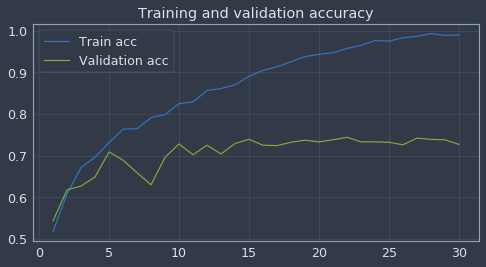

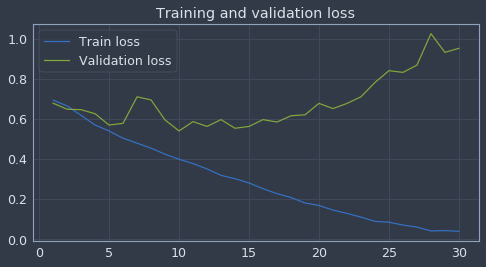

In [17]:
""" <코드 5-10> 훈련의 정확도와 손실 그래프 그리기 """

import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(figsize=(10.0, 5.0))

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Train acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # 그래프를 나눌 때 사용

plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

위 그래프는 과대적합의 특성을 보여준다. 훈련 정확도는 거의 100%에 도달하지만 검증 정확도는 70~72%에 머무른다. 비교적 훈련 샘플의 수가 적은 상황에서 과대적합의 처리는 매우 중대한 문제이며 드롭아웃이나 가중치 감소(L2 규제)를 사용할 수 있지만, 딥러닝으로 이미지를 다룰 때 매우 일반적으로 사용되는 <u><b>데이터 증식</b></u>을 시도해보자.

### 5.2.5 데이터 증식 사용하기
케라스에서는 imageDataGenerator가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있다. 

In [18]:
""" <코드 5-11> ImageDataGenerator를 사용하여 데이터 증식 설정하기 """
datagen = ImageDataGenerator(
    rotation_range=20,      # 랜덤하게 사진을 회전시킬 각도 범위(0~180), 예제는 -20 ~ +20
    width_shift_range=0.1,  # 사진을 수평으로 랜덤하게 평행이동 시킬 범위(전체 너비에 대한 비율), 1 이상이면 픽셀 값으로 간주하여 -W ~ +W가 됨
    height_shift_range=0.1, # 사진을 수직으로 랜덤하게 평행이동 시킬 범위(전체 높이에 대한 비율), 1 이상이면 픽셀 값으로 간주하여 -H ~ +H가 됨
    shear_range=0.1,        # 전단 변환(y축 회전)을 적용할 각도 범위
    zoom_range=0.1,         # 랜덤하게 사진을 확대할 범위
    horizontal_flip=True,   # 수평으로 뒤집어 출력
    fill_mode='nearest'     # 회전이나 가로/세로 이동으로 인해 새롭게 생성해야할 픽셀을 채울 전략
)

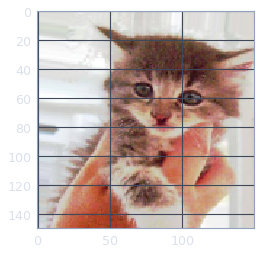

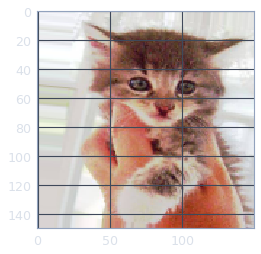

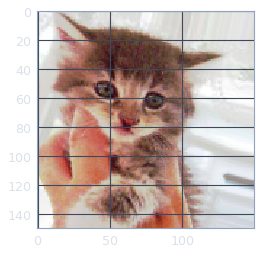

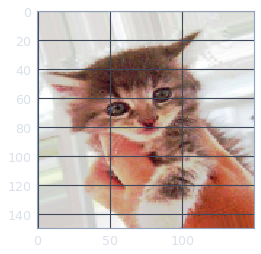

In [20]:
""" <코드 5-12> 랜덤하게 증식된 훈련 이미지 그리기 """
from keras.preprocessing import image

fnames = sorted([train_cats_dir / fname 
                 for fname in train_cats_dir.iterdir()])

img_path = fnames[3] # 증식할 이미지 선택
img = image.load_img(img_path, target_size=(150, 150)) # 이미지를 앍고 크기를 변환

x = image.img_to_array(img)   # (150, 150, 3) 크기의 넘파이 배열로 변환
x = x.reshape((1,) + x.shape) # (1, 150, 150, 3) 크기로 변환

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()    